In [65]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import random, os
import numpy as np
import torch
import importlib
import deeptrack as dt
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from objVAE import vae, fg, bg
from objVAE import objVAE, MultiheadAttention
from objVAE import utils


def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(42)

In [21]:
def plot_training(model, test_loader, presence=True, trainer=''):
    # forwards pass
    # model.eval()

    x = next(iter(test_loader))
    x = x[:1]
    x = x.to(model.device)

    if presence:
        (
            recon,
            kl_divergence,
            background_kl,
            xy,
            background,
            x_hat,
            z_pres,
            attention,
        ) = model(x)
        alpha = z_pres[0].detach().cpu().numpy() > 0.25
        xy = xy.detach().cpu().numpy()[0, alpha]
        edge_color = plt.cm.get_cmap('spring')(z_pres[0, alpha].detach().cpu().numpy())

    else:
        (
            recon,
            kl_divergence,
            background_kl,
            xy,
            background,
            x_hat,
            z_pres,
            attention,
        ) = model(x)
        xy = xy.detach().cpu().numpy()[0, :]
        edge_color = 'r'


    plt.figure(figsize=(20, 20))
    plt.subplot(2, 2, 3)
    plt.imshow(x[0, 0, 0, :, :].detach().cpu().numpy(), cmap="gray")
    
    plt.scatter(xy[:, 1], xy[:, 0], s=10, edgecolors=edge_color, facecolor="none")
    
    plt.title("Input image")
    
    plt.subplot(2, 2, 4)
    plt.imshow(
        recon[0, 0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, 0, :, :].min(),
        vmax=x[0, 0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("Reconstruction")

    plt.subplot(2, 2, 1)
    plt.imshow(
        background[0, 0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, 0, :, :].min(),
        vmax=x[0, 0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("background")

    plt.subplot(2, 2, 2)
    plt.imshow(
        x_hat[0, 0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, 0, :, :].min(),
        vmax=x[0, 0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("forground")

    plt.savefig(f"../results/training/fig_{trainer.current_epoch}.png")

    return plt

(48, 278, 331)
torch.Size([12, 4, 1, 256, 256])


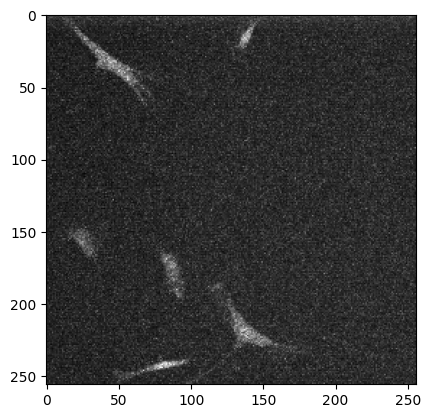

In [16]:
import tifffile
from glob import glob
import cv2

x_crop = 256
y_crop = 256

paths = r'/data/mp_mpa/Fluo-C2DL-MSC/*.tif'
paths = sorted(glob(paths))

images = [
    tifffile.imread(path) for path in paths
]
 
images = np.array(images)[:90, ::3, ::3]
print(images.shape)

images = np.array(np.split(images, 12, axis=0))

images_array = []
#for i in range(images.shape[2] // x_crop):
#    for j in range(images.shape[3] // y_crop):
#        images_array.append(images[:, :, (i)*x_crop:(i+1)*x_crop, (j)*y_crop:(j+1)*y_crop])


#images = np.concatenate(images_array, axis=0)
images = images[:, :, :x_crop, :y_crop]

images = np.abs((images-np.min(images))/(np.max(images)-np.min(images)))

training_images = torch.tensor(np.array(images), dtype=torch.float32)
training_images = training_images - torch.mean(training_images)
training_images = training_images / torch.std(training_images, dim=(1, 2, 3), keepdim=True) / 3
training_images = torch.unsqueeze(training_images, axis=2)
print(training_images.shape)
plt.imshow(np.squeeze(training_images[0,2,:,:,:]), cmap='gray')

In [17]:
train, test = torch.utils.data.random_split(training_images, [0.8, 0.2])
train_loader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

In [59]:
import IPython.display as ipd

# Callbacks
max_steps = 10000
beta_annealing_end = max_steps
lr_annealing_end = max_steps
kl_annealing_end = 24000 # 2400
presence_annealing_end = 1000

def beta_annealing(step):
    logs = np.logspace(-8.3, -4, beta_annealing_end) # 8.3 - 7
    if step < beta_annealing_end:
        return logs[int(step)]
    else:
        return logs[-1]
    
def kl_annealing(step):
    logs = np.linspace(0, 1, kl_annealing_end)
    if step < kl_annealing_end*0.5:
        return 0
    if step < kl_annealing_end:
        return logs[step]
    else:
        return 1

def presence_annealing(step):
    lins = np.linspace(1, 0, presence_annealing_end)
    if step < presence_annealing_end:
        return lins[step]
    else:
        return 0
    
def lr_annealing(step):
    logs = np.logspace(-3, -5, lr_annealing_end)
    
    if step < lr_annealing_end:
        return logs[step]
    else:
        return logs[-1]


class AnCallbacks(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        step = trainer.global_step
        pl_module.model.beta = beta_annealing(step)
        pl_module.model.presence_bias = presence_annealing(step)
        pl_module.optimizers().lr = lr_annealing(step)
        pl_module.model.kl_importance = kl_annealing(step)


class PlotCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % 10:
            return
        ipd.clear_output(wait=True)
        plot_training(model, test_loader, presence=True, trainer=trainer)
        plt.suptitle(f"Epoch {trainer.current_epoch}")
        plt.show()


In [18]:
import IPython.display as ipd
import pytorch_lightning as pl

# Callbacks
max_steps = 12000
beta_annealing_end = max_steps
lr_annealing_end = max_steps
kl_annealing_end = 0#3400 # 2400
presence_annealing_end = 2500
unfreeze = 0

def beta_annealing(step):
    logs = np.logspace(-10.3, -8, beta_annealing_end) # 8.3 - 7
    if step < unfreeze:
        return logs[0]
    if step < beta_annealing_end:
        return logs[int(step)-unfreeze]
    else:
        return logs[-1]
    
def kl_annealing(step):
    logs = np.linspace(0, 1, kl_annealing_end)
    if step < kl_annealing_end*0.5:
        return 0
    if step < kl_annealing_end:
        return logs[step]
    else:
        return 1

def presence_annealing(step):
    lins = np.linspace(1, 0, presence_annealing_end)
    if step < presence_annealing_end:
        return lins[step]
    else:
        return 0
    
def lr_annealing(step):
    logs = np.logspace(-3, -5, lr_annealing_end)
    
    if step < lr_annealing_end:
        return logs[step]
    else:
        return logs[-1]
    
def unfreeze_foreground(step):
    for param in model.model.parameters():
        param.requires_grad = True



class AnCallbacks(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        step = trainer.global_step
        pl_module.model.beta = beta_annealing(step)
        pl_module.model.presence_bias = presence_annealing(step)
        pl_module.optimizers().lr = lr_annealing(step)
        pl_module.model.kl_importance = kl_annealing(step)

class UnfreezeCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch == 100:
            unfreeze_foreground(model)


class PlotCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.global_step % 100:
            return
        ipd.clear_output(wait=True)
        plot_training(model, test_loader, presence=True, trainer=trainer)
        plt.suptitle(f"Epoch {trainer.current_epoch}")
        plt.show()


In [60]:
importlib.reload(objVAE)
importlib.reload(MultiheadAttention)

load_model = ""

#load_model = "../state_dicts/model-musc-bg.pth"
#load_model = "../state_dicts/model-microtubuler-256px-bad.pth"


use_attention = True
num_entities = 10
softmax_tmp = 1
latent_dim = 5
beta = 1e-4
number_of_heads = 1
object_radius = 30
combine_method = "sum"
topk_select_method = 'max'
decoder="linnear"
decoder_feature_size=56 #56
encoder_num_layers=3
decoder_num_layers=10

single_decoder = True
attention_mechanism='cosine-similarity'

bg_params = {
    'decoder_activation': 'relu',
    'decoder_channels': 60,
    'decoder_norm': 'batch',
    'decoder_depth': 4,
    'encoder_activation': 'relu',
    'encoder_channels': 36,
    'encoder_norm': 'instance',
    'encoder_depth': 4,
    'hidden_dim': 2, #12
    'position_dim': 128
}

background_model = bg.objBG(in_channels=1,image_size=256, **bg_params)
    

attention = MultiheadAttention.MultiheadAttention(
    max_t=1, attention_mechanism=attention_mechanism, softmax_factor=softmax_tmp, number_of_heads=1, num_filters=latent_dim-2
)
model = objVAE.MEVAE(
    num_entities,
    attention_model=attention,
    background_model=None,
    beta=beta,
    latent_dim=latent_dim,
    attention=use_attention,
    glimpse_size=object_radius,
    combine_method=combine_method,
    topk_select_method=topk_select_method,
    single_decoder = single_decoder,
    decoder=decoder,
    decoder_feature_size = decoder_feature_size,
    encoder_num_layers=encoder_num_layers,
    decoder_num_layers=decoder_num_layers
)


if load_model:
    model.load_state_dict(torch.load(load_model))

for param in model.model.parameters():
    param.requires_grad = False


In [61]:
for param in model.model.parameters():
    param.requires_grad = True

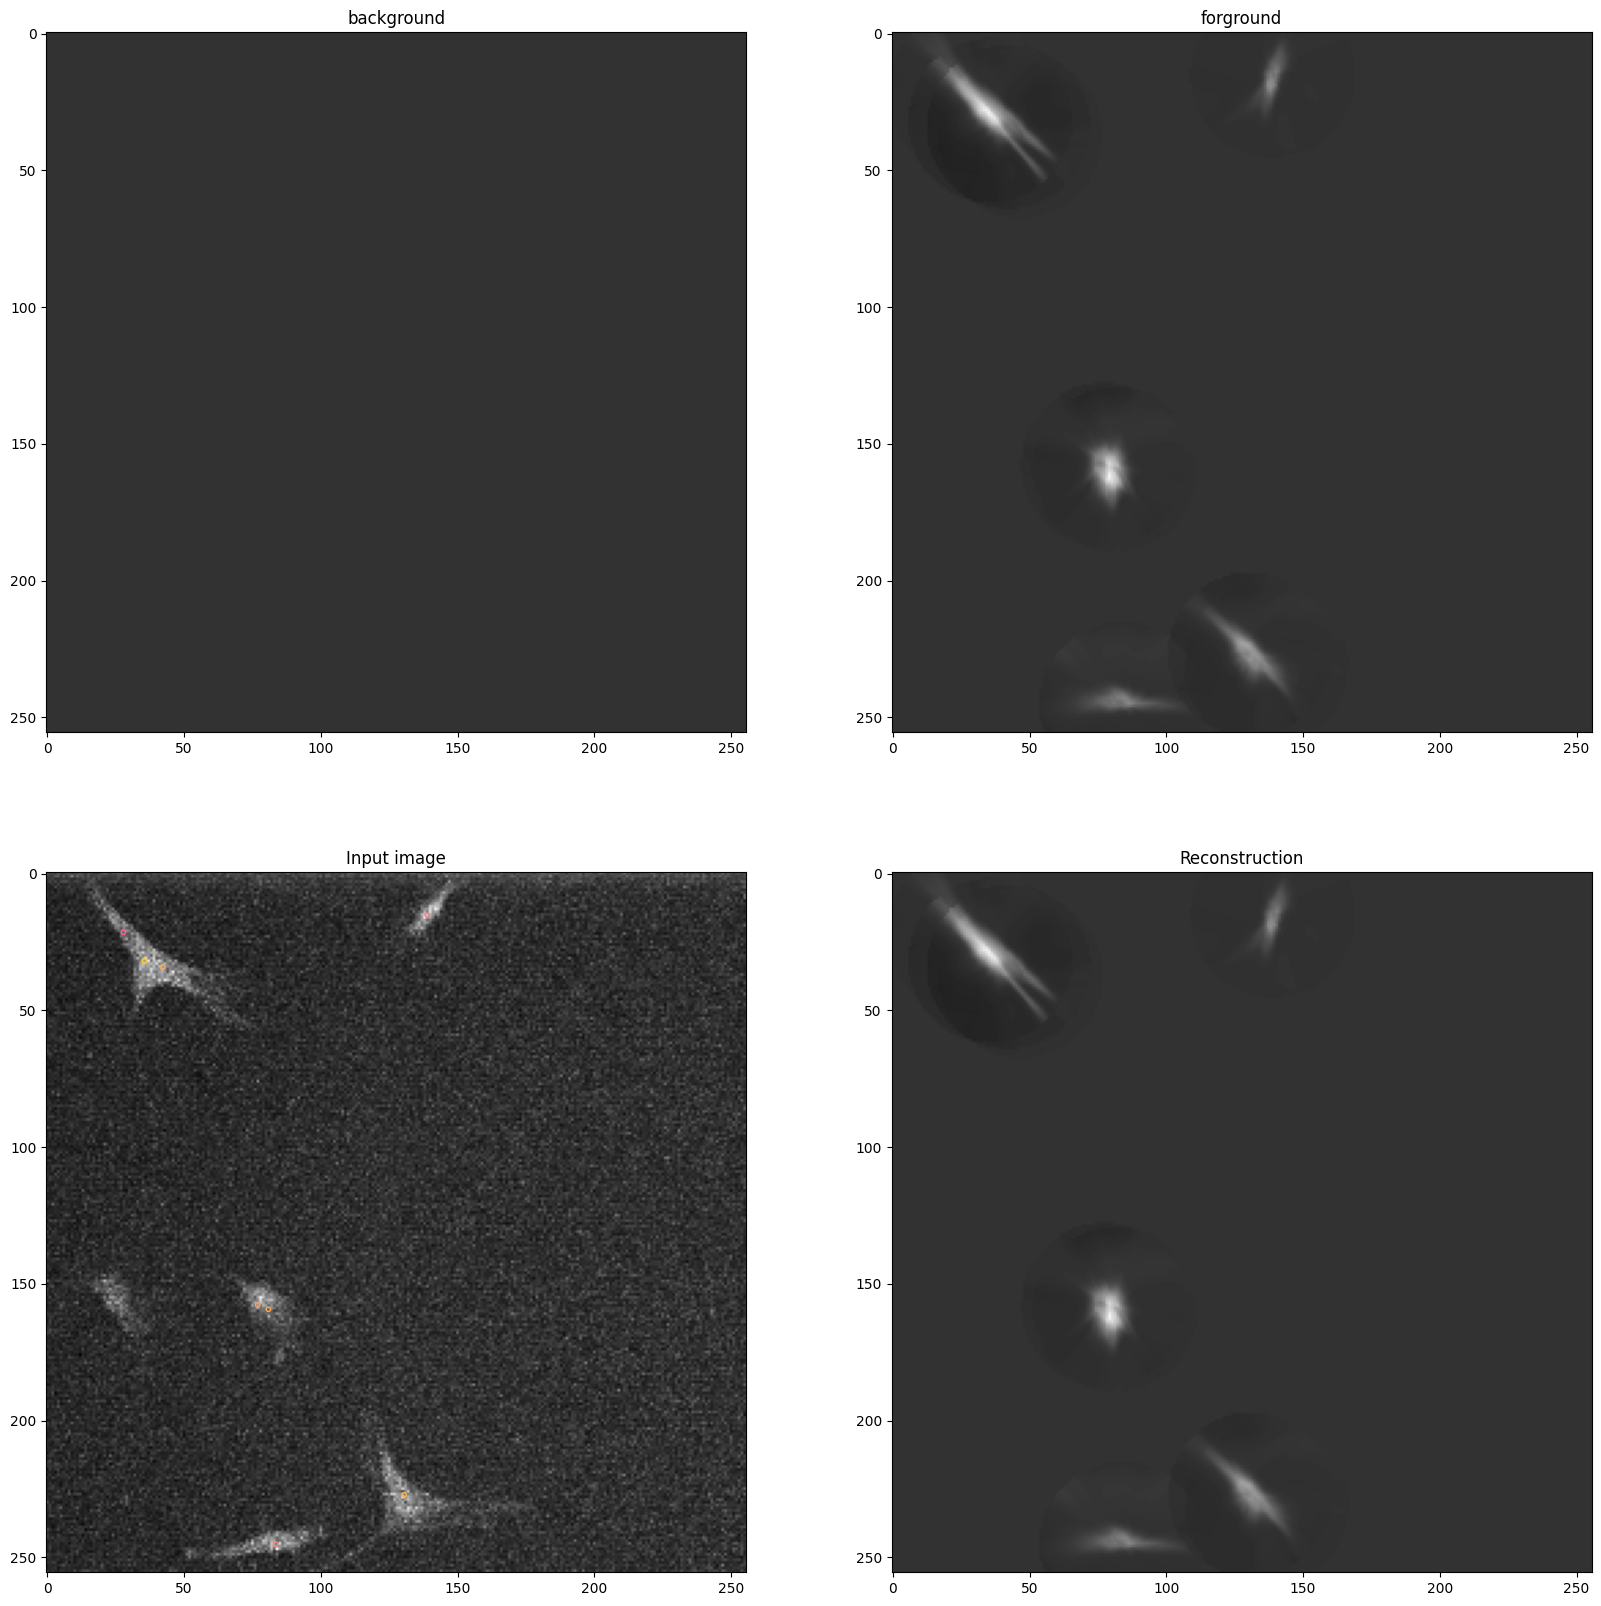

In [62]:
trainer = pl.Trainer(max_steps=max_steps, callbacks=[AnCallbacks(), PlotCallback()])
trainer.fit(model, train_loader, test_loader)

...........
{'x': [34.097168], 'y': [42.11281], 'code': [-1], 'start': 0, 'end': 0}
{'x': [22.047148], 'y': [27.733654], 'code': [-1], 'start': 0, 'end': 0}
{'x': [157.49112], 'y': [76.992516], 'code': [-1], 'start': 0, 'end': 0}
{'x': [245.13477, 246.38745], 'y': [83.69525, 71.192726], 'code': [-1, -1], 'start': 0, 'end': 1}
{'x': [214.3591], 'y': [132.41254], 'code': [-1], 'start': 2, 'end': 2}
{'x': [227.137, 225.99898, 219.20044, 217.78241], 'y': [130.49544, 136.55023, 138.60342, 140.24222], 'code': [-1, -1, -1, -1], 'start': 0}
{'x': [15.2256365, 15.723796, 15.937138, 16.73179], 'y': [138.72346, 138.38593, 136.87898, 136.68068], 'code': [-1, -1, -1, -1], 'start': 0}
{'x': [31.709482, 33.61392, 33.654213, 35.360382], 'y': [35.246414, 43.431114, 44.434696, 45.105606], 'code': [-1, -1, -1, -1], 'start': 0}
{'x': [39.94955, 40.162704], 'y': [51.618816, 52.33367], 'code': [-1, -1], 'start': 2}
{'x': [159.34877, 164.88734, 157.98367, 158.07732], 'y': [80.89656, 81.956696, 25.997057, 24.

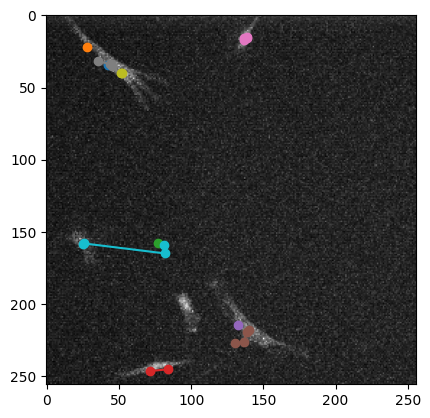

In [63]:
seq = test[0]

tra_list = model.extract_obj_and_tra(seq, 4, presence_floor=0.25, tra_floor=0.0)

print('...........')
plt.imshow(seq[-1][0], cmap='gray')
for i, dict in enumerate(tra_list):
    print(dict)
    plt.plot(dict.get('y'), dict.get('x'), '-o')
plt.show()

/workspace/aa-attention/objVAE/objVAE/utils.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20, 10))


Epoch 19: 100%|██████████| 5/5 [1:04:44<00:00, 776.96s/it, v_num=1994, loss_step=0.123, recon_loss_step=0.123, kl_loss_step=4.230, kl_for_step=0.261, kl_back_step=3.970, loss_epoch=0.123, recon_loss_epoch=0.123, kl_loss_epoch=3.930, kl_for_epoch=0.260, kl_back_epoch=3.660]


<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

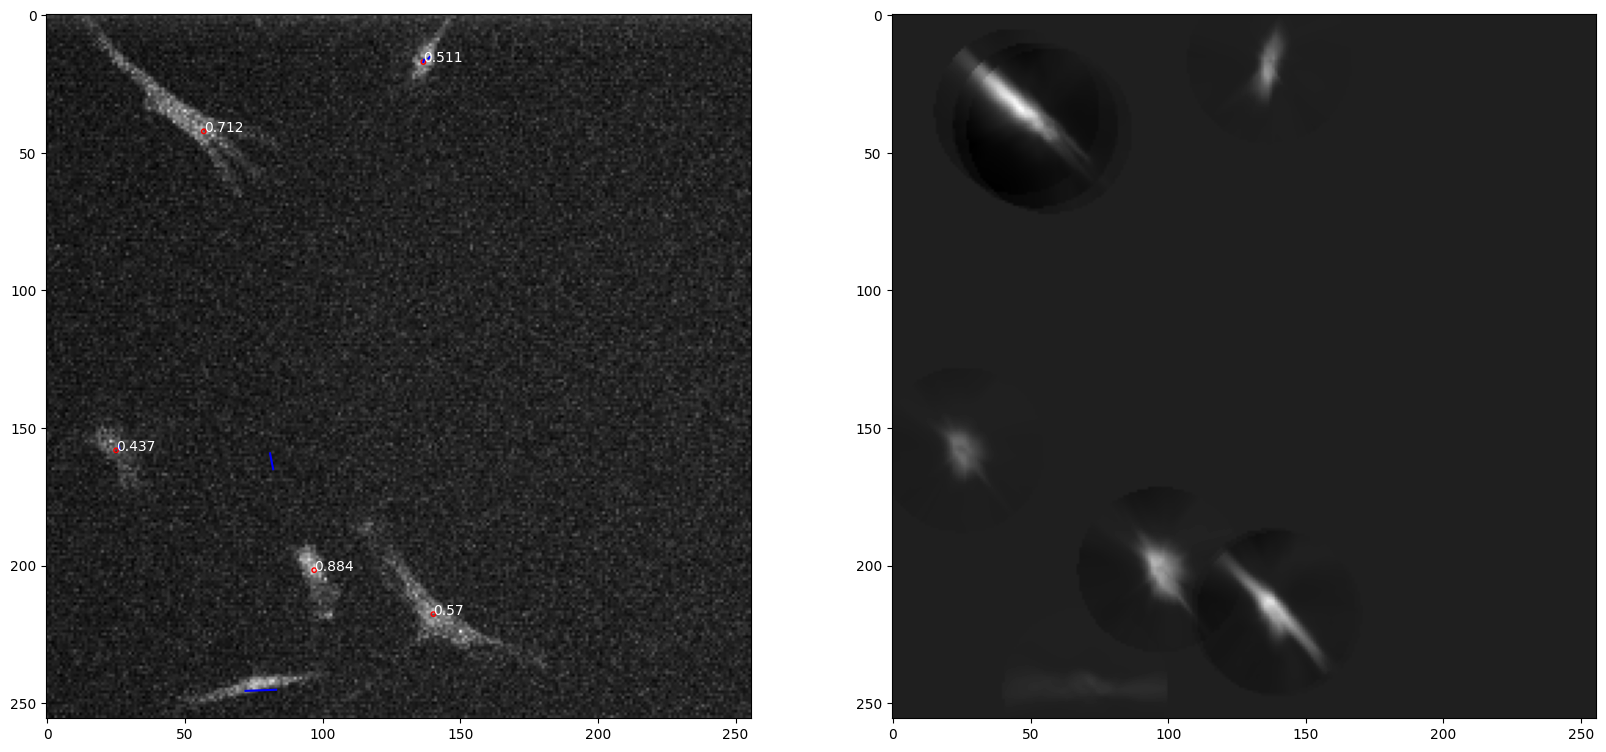

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

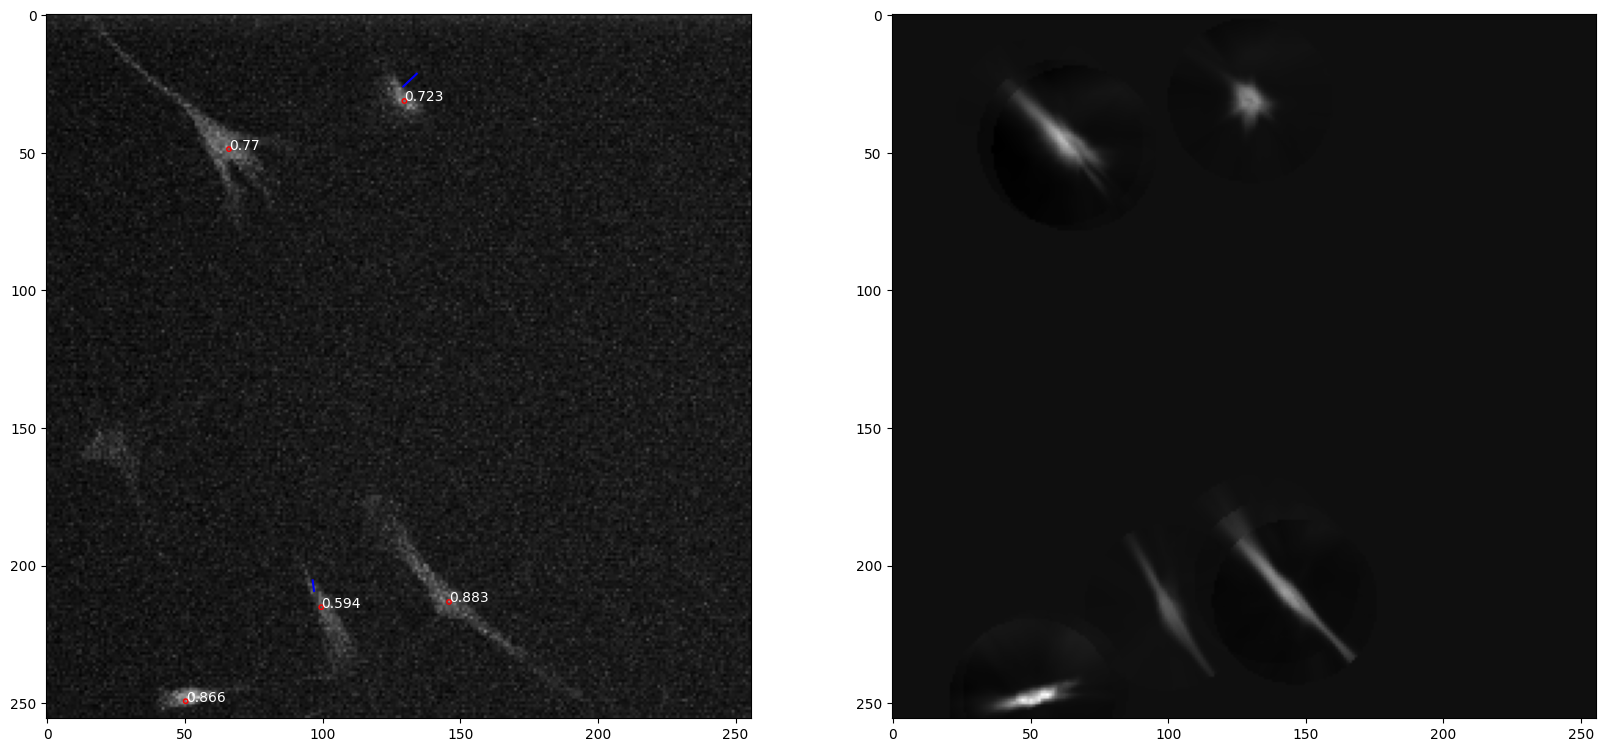

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

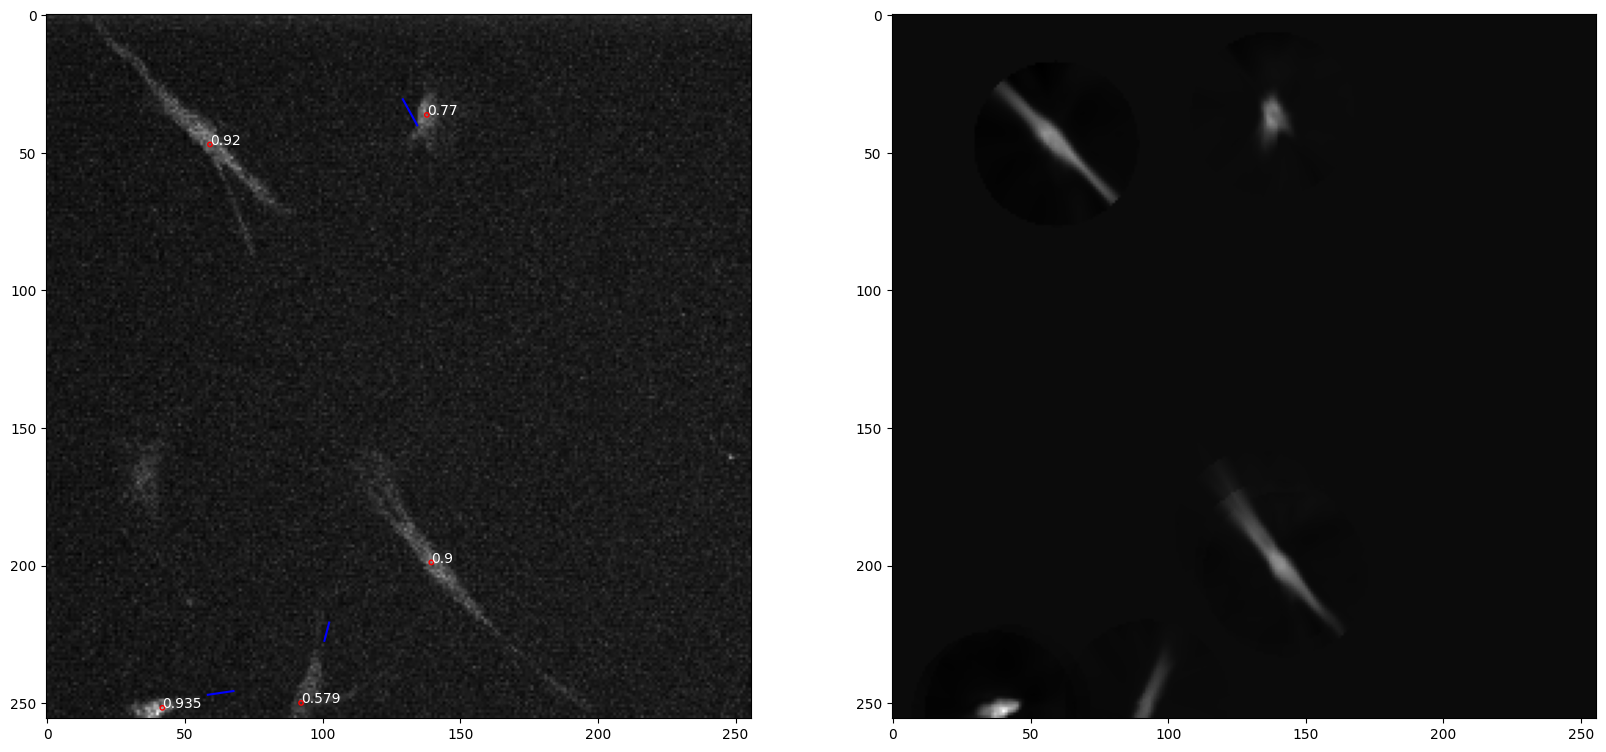

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

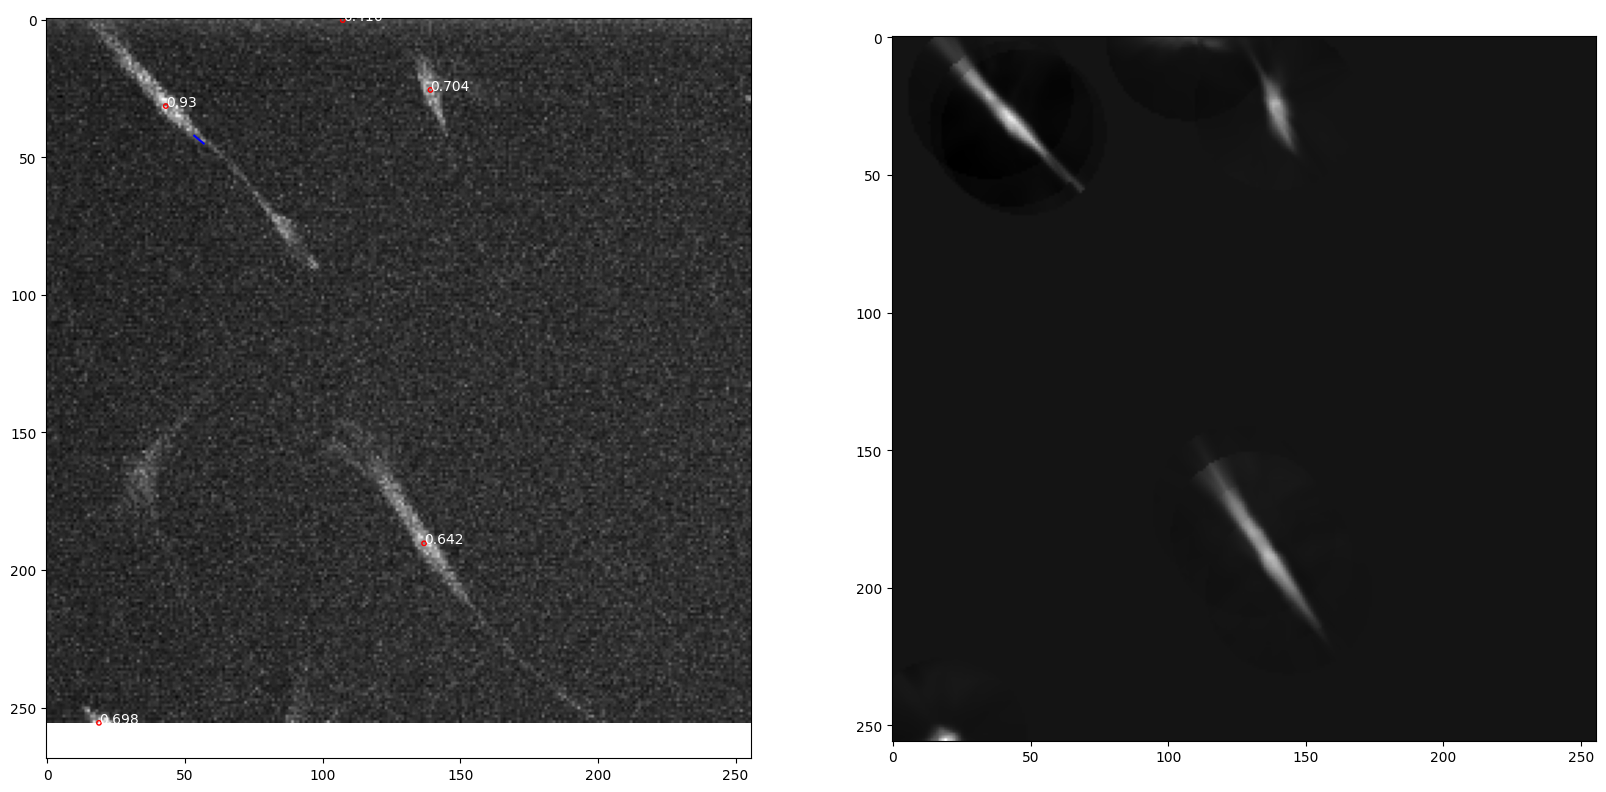

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

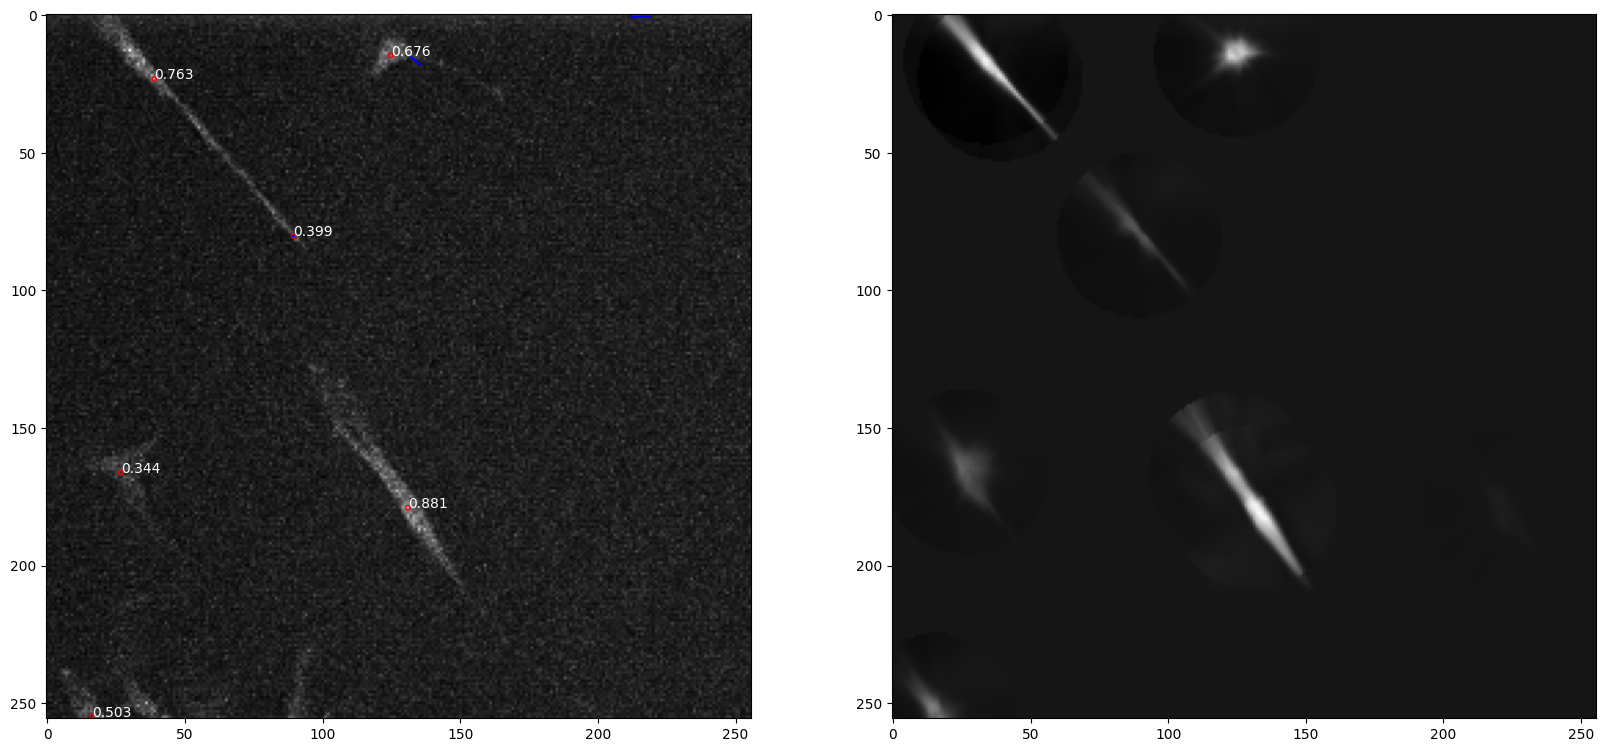

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

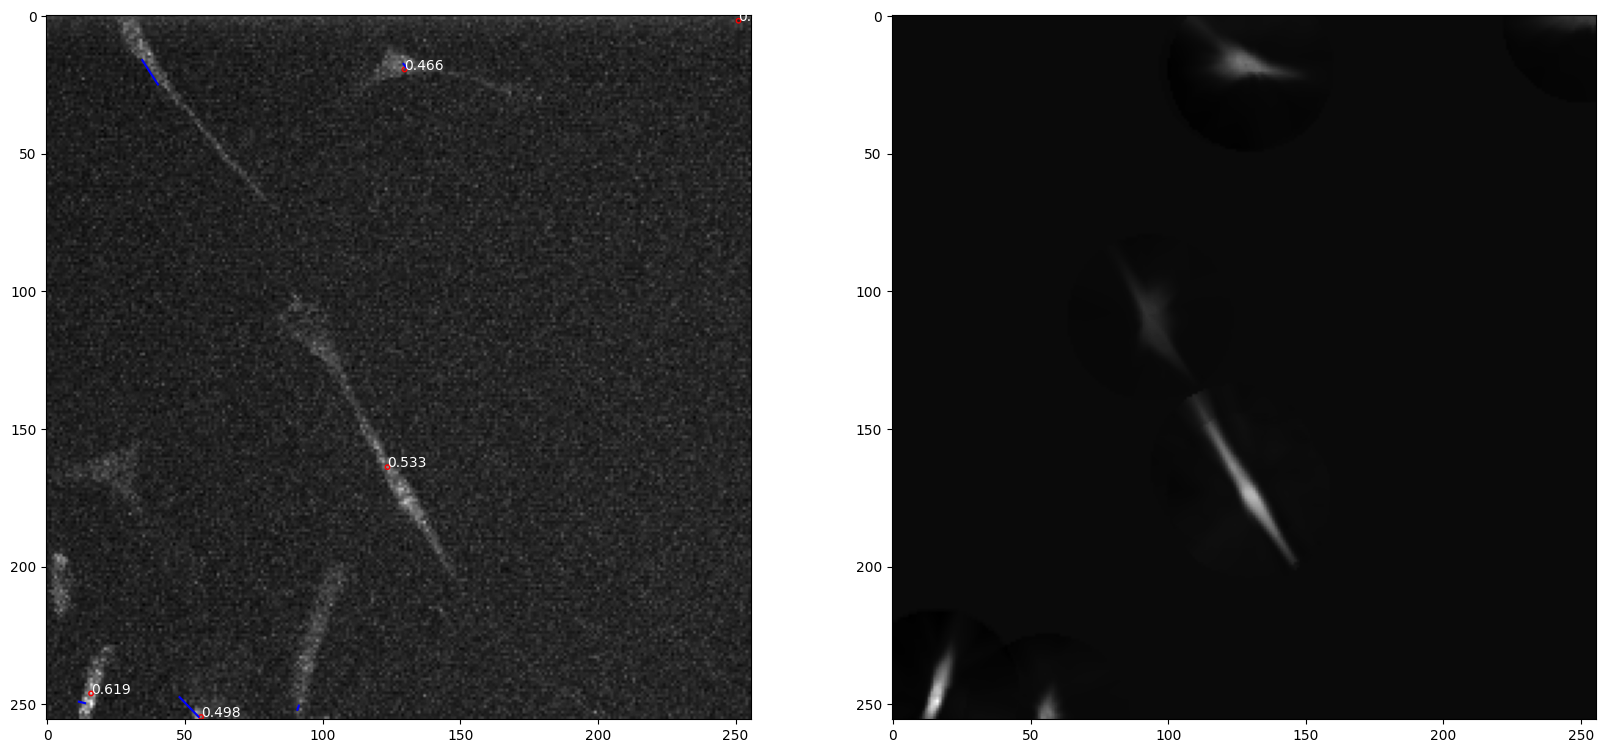

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

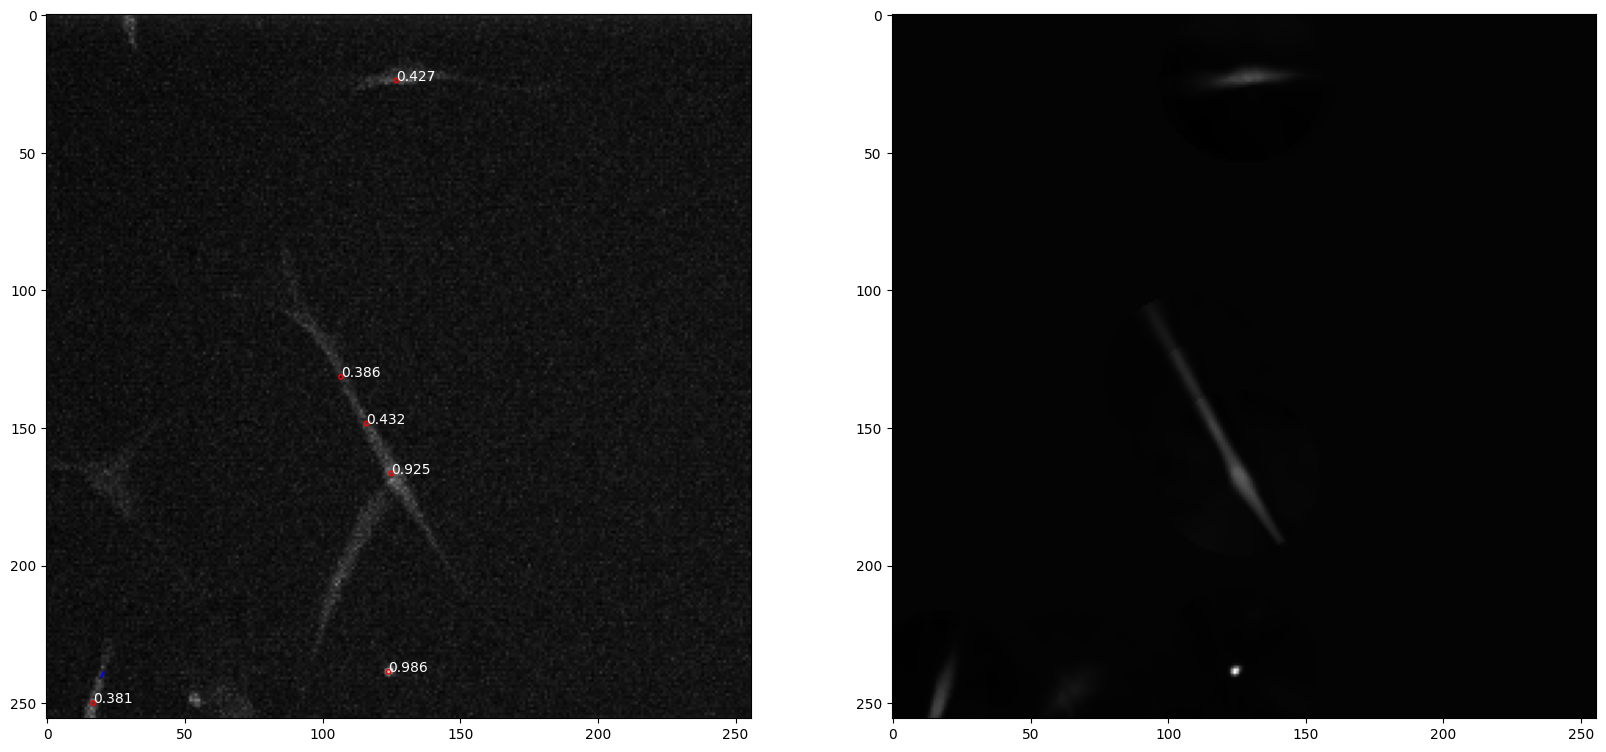

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

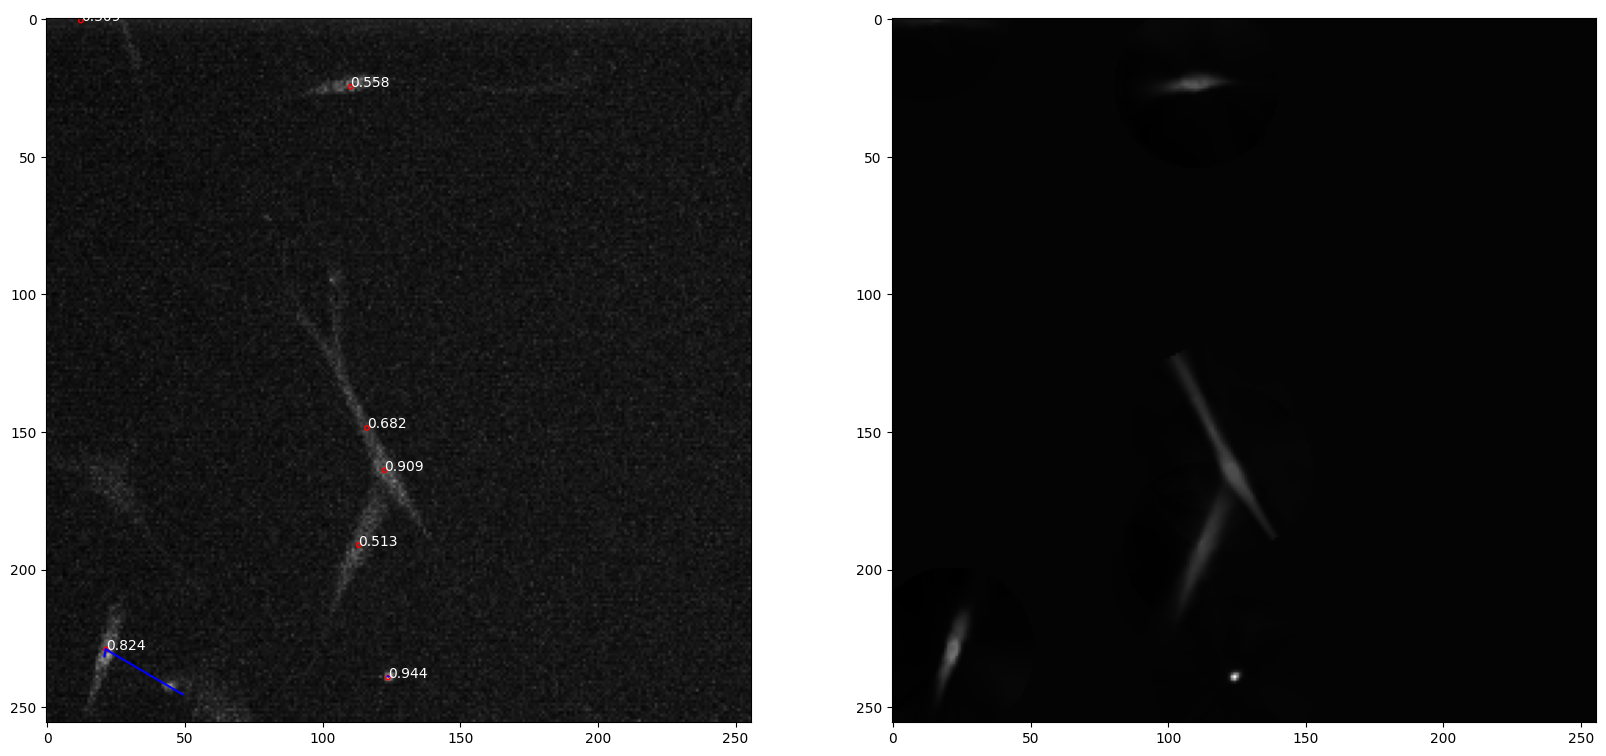

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

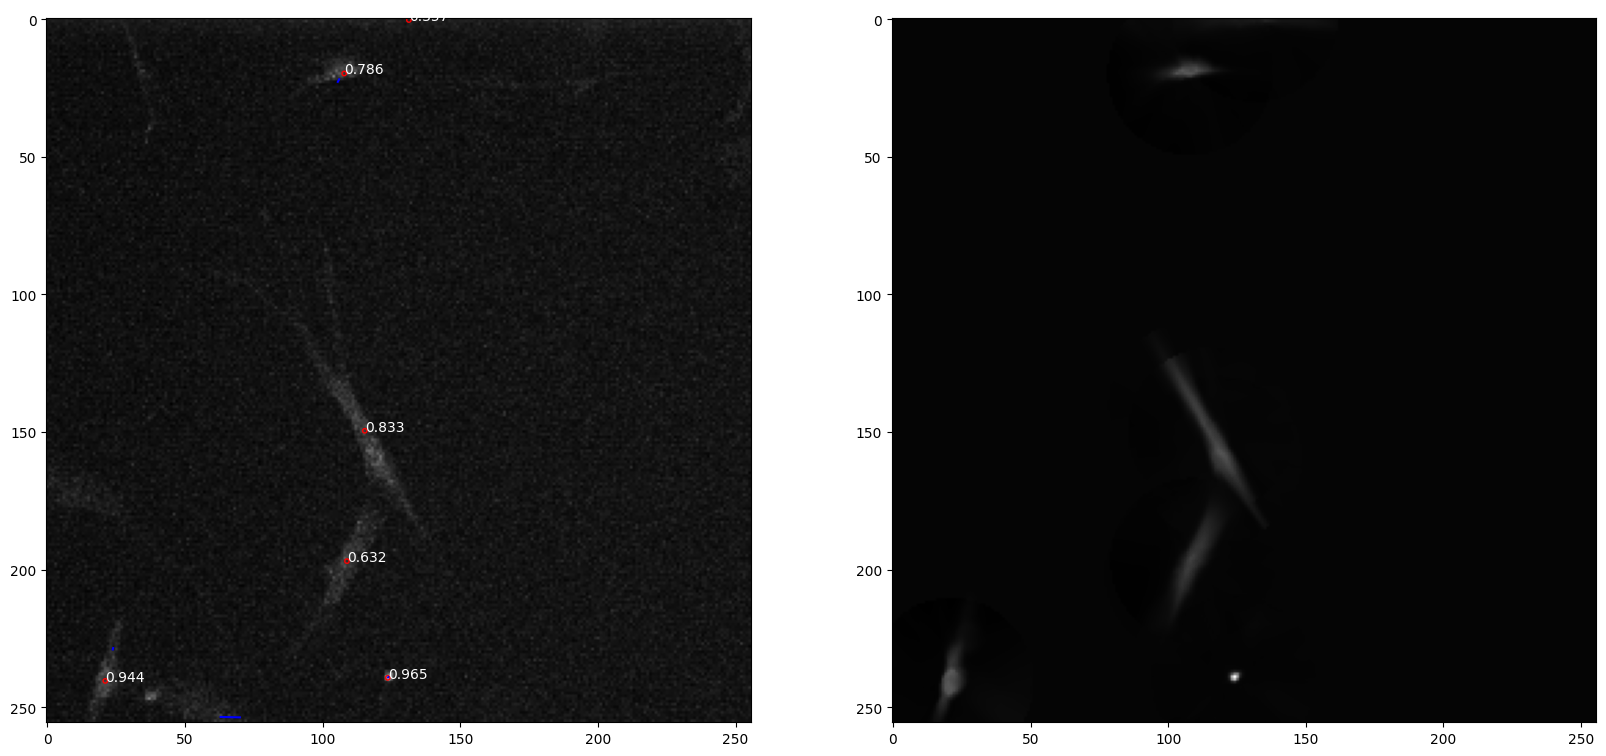

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

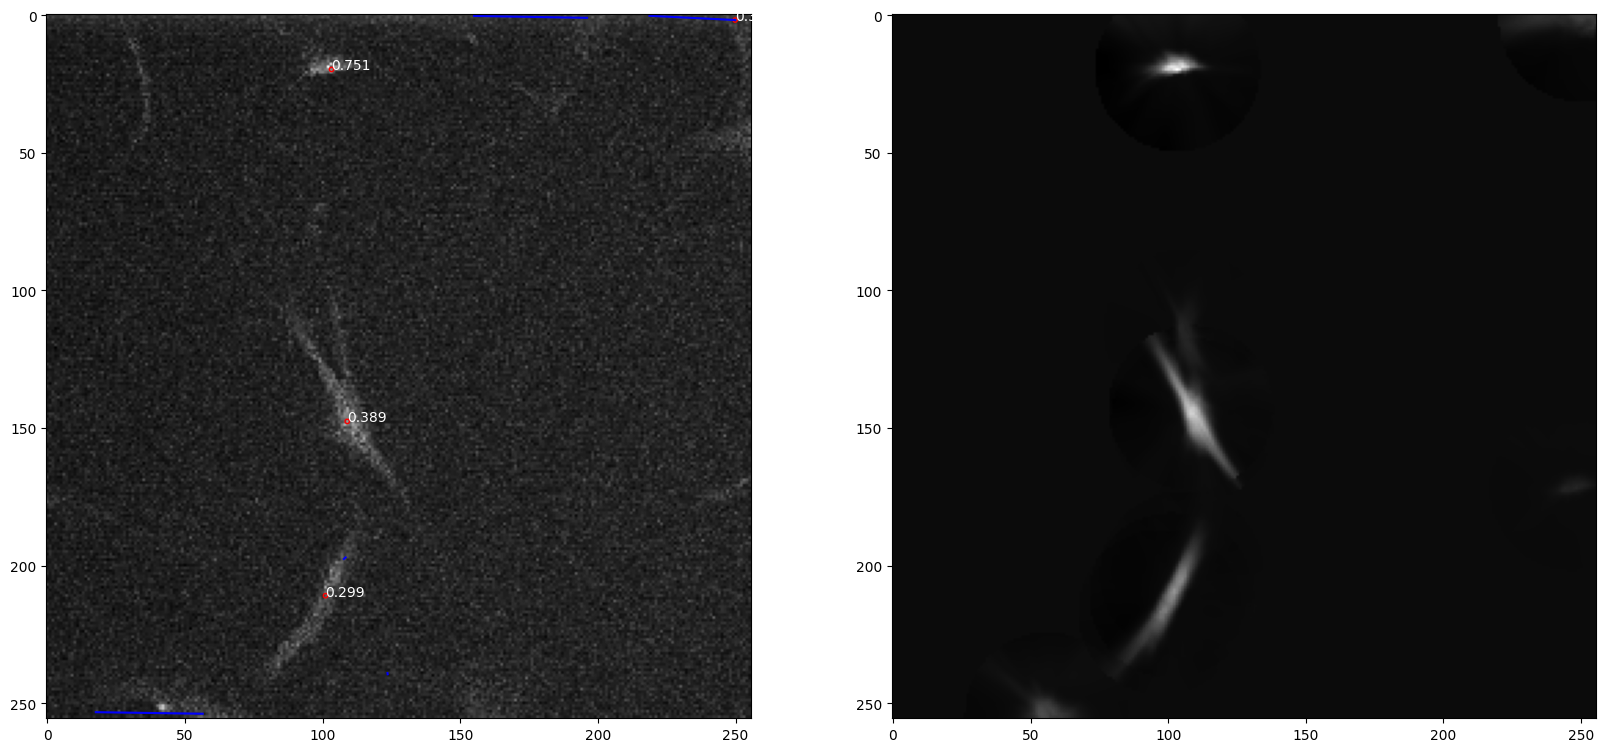

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

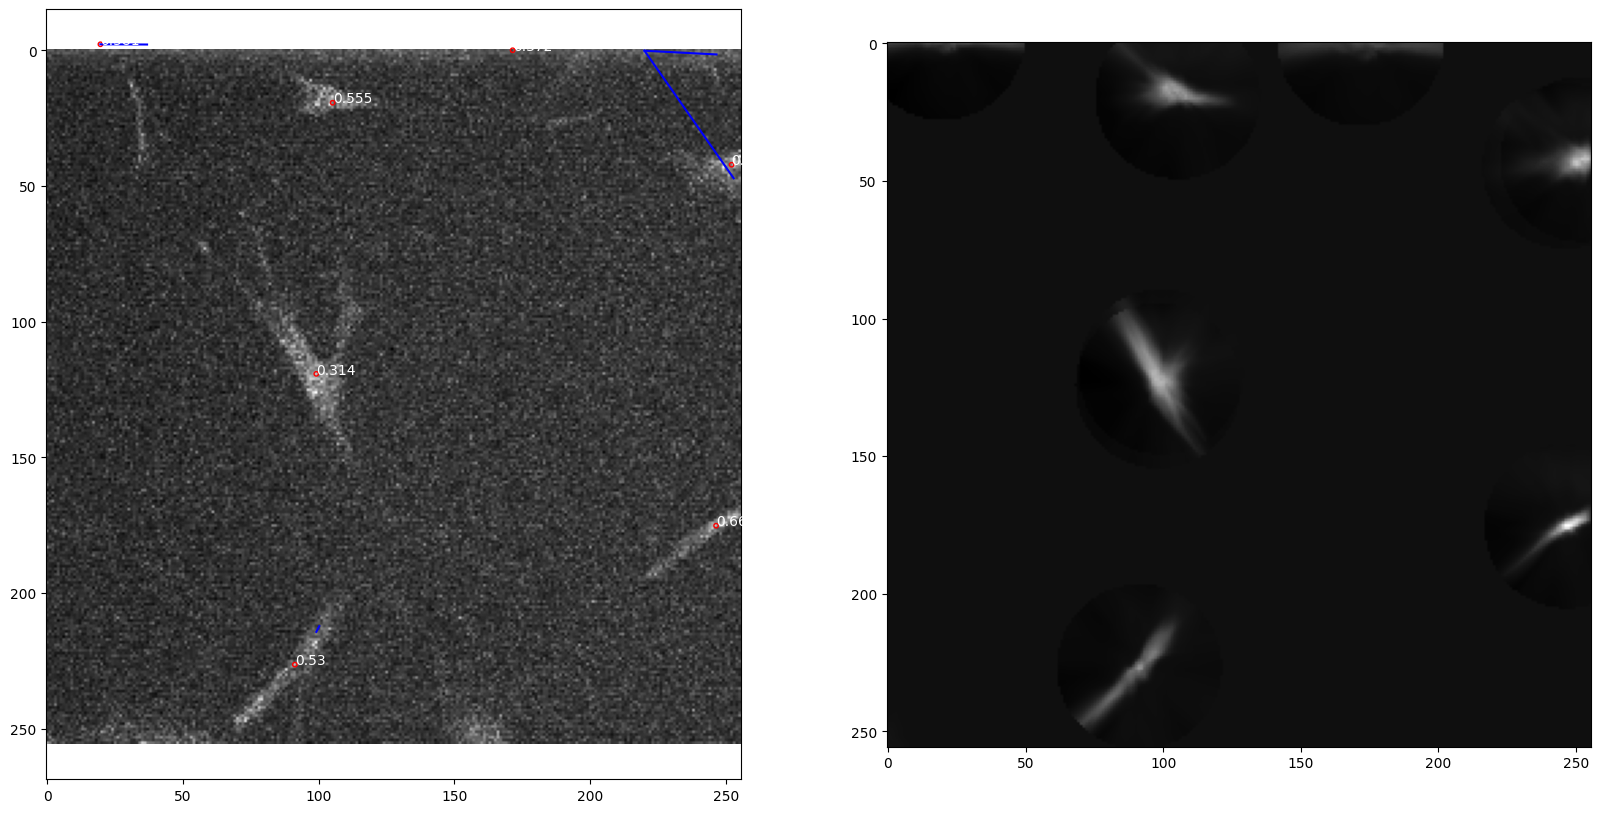

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

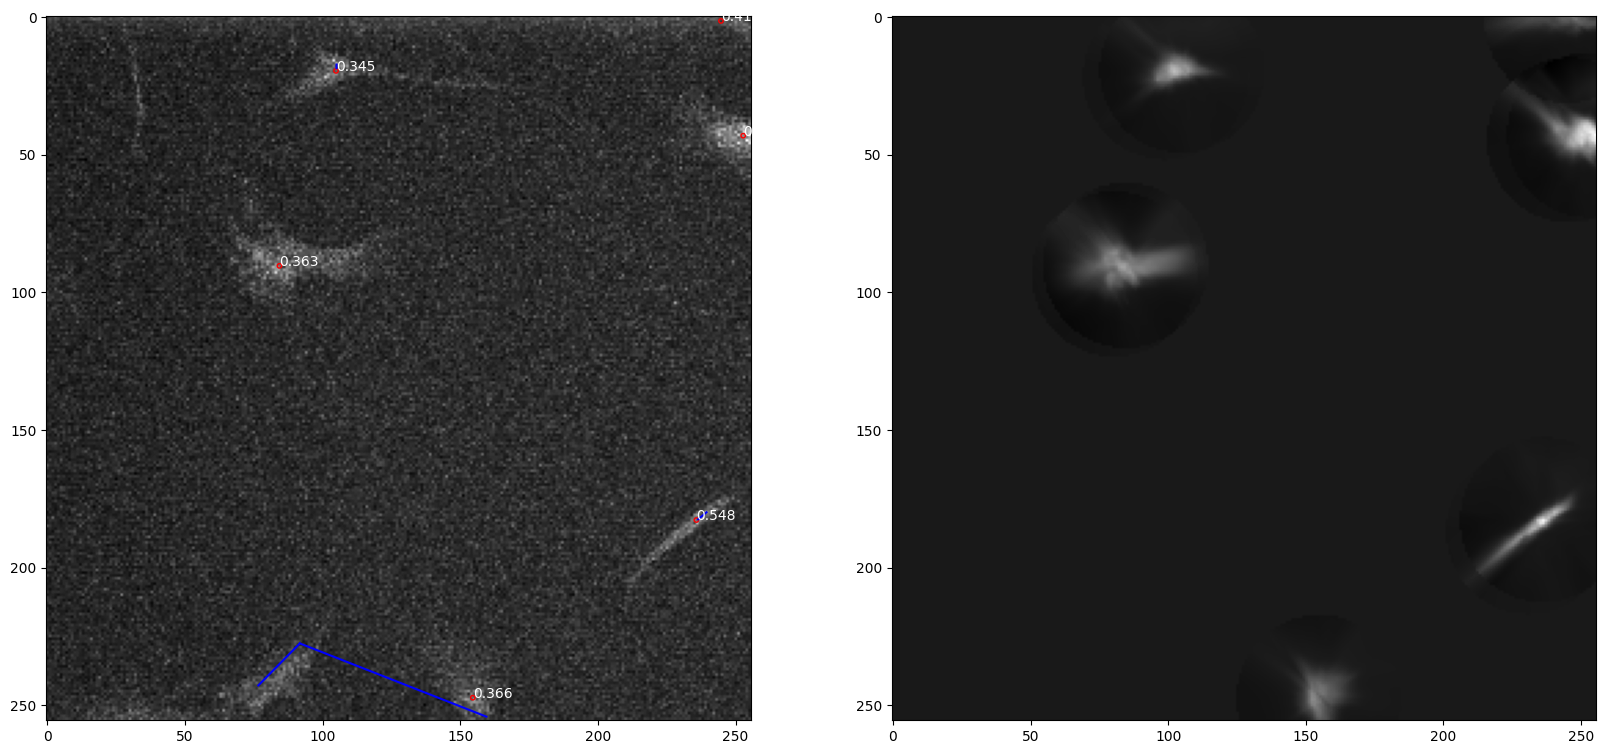

In [68]:
utils.run_test(
    training_images,
    model,
    combine_radius=16,
    plot_num=None,
    num_entities=10,
    pres_floor=0.25,
    tra_floor=0.5
    )

In [ ]:
torch.save(model.state_dict(), "../state_dicts/model-MSC.pth")